## Yelp Project

### Import Dependencies

In [37]:
import requests
from API_key import api_key #separate .py script containing function which returns my API key
#import geopy
import folium

import matplotlib.pyplot as plt
#import reverse_geocoder as rg
import seaborn as sb
import pandas as pd
import numpy as np
import time
import json

### Gather data using API

First we shall gather the relevant data regarding businesses stored by Yelp. We shall use an API key to send call requests to return data with a parameter dictionary to customise the data we get. For our purposes, we only want all businesses within London. The API key that we use to do this prosess is stored in another file called *API_key* and is then imported to conceal the actual API key value.

In [96]:
API_key = api_key() #returns our API key

def gather_data(API_key):
    '''Function that calls from the API using the given API key to gather data from yelp reviews of restaurants from London.
    INPUT
    -----
    API_key: str
        API key string used to send requests for our data

    RETURN
    ------
    all_restaurants: list
        list of dictionaries of the infomation for each location
    '''
    endpoint = "https://api.yelp.com/v3/businesses/search" #endpoint for data gathering
    headers = {
        'Authorization': f'bearer {API_key}' #header for authentication
    }
    num_requests = 0 #initial number of request loops
    all_restaurants = [] #initial list of collected dictionaries
    while True:
        parameters = {
            'location': 'London', #we want to find restaurants in London
            'limit': 50, #default limit is 50
            'offset': 1 + 50*num_requests #sets starting point for collection
        }
        if parameters['limit'] + parameters['offset'] > 1000: #error produced from responce variable if this criteria is broken
            break #break while loop
        response = requests.get(url = endpoint, params = parameters, headers = headers) #gather desired data in form of JSON file
        restaurants = response.json() #convert JSON to list of dictionary
        all_restaurants += restaurants['businesses'] #add dictionaries to list of total data
        num_requests += 1 #add one to value of variable
    return all_restaurants, restaurants['region']['center']

all_restaurants, center_of_search = gather_data(API_key) #list of dictionaries of all restaurants allowed to gather
print(f'Collected {len(all_restaurants)} restaurant\'s data.') #prints message informing total number of businesses' data collected
center_latitude, center_longitude = center_of_search['latitude'], center_of_search['longitude']
print(f'Center of the businesses data search:\n\nLatitude: {center_latitude},\nLongitude: {center_longitude}.')

Collected 950 restaurant's data.
Center of the businesses data search:

Latitude: 51.51283552118349,
Longitude: -0.135955810546875.


API request from Yelp does not allow for the gathering of 1000 or more data points. Thus, we are forced to set the number of data points used for this project to 950. This isn't too bad of a compromise but concerns may may start if we are forced to delete too many rows during Data Cleaning. Before cleaning can proceed, we must convert our data into a Pandas Dataframe. 

### Convert data into Pandas Dataframe

In [3]:
df = pd.DataFrame(all_restaurants) #convert our list of dictionaries into a pandas dataframe
display(df.head()) #print top 5 entries to check convertion held

id                          alias  \
0  YRA2VnhFLChIh1ZD31cXjg      the-british-museum-london   
1  mc1KLbA1Sy4kUTKo0ZEeRQ               dishoom-london-7   
2  ElxBJGffVB-jV1kMCG9PbQ  the-national-gallery-london-2   
3  v1Lpwqs75mmQ0ugugoqTvA       tower-of-london-london-2   
4  NPAkaFjtmDC8IKC60u5PAw    coca-cola-london-eye-london   

                   name                                          image_url  \
0    The British Museum  https://s3-media3.fl.yelpcdn.com/bphoto/7miqMp...   
1               Dishoom  https://s3-media2.fl.yelpcdn.com/bphoto/bnu8b8...   
2  The National Gallery  https://s3-media3.fl.yelpcdn.com/bphoto/4BJTgx...   
3       Tower of London  https://s3-media1.fl.yelpcdn.com/bphoto/GCoS_4...   
4  Coca Cola London Eye  https://s3-media1.fl.yelpcdn.com/bphoto/FZJ4ky...   

   is_closed                                                url  review_count  \
0      False  https://www.yelp.com/biz/the-british-museum-lo...          1086   
1      False  https://www.yelp.com/biz/dishoom-london-7?adju...           630   
2      False  https://www.yelp.com/biz/the-national-gallery-...           491   
3      False  https://www.yelp.com/biz/tower-of-london-londo...           712   
4      False  https://www.yelp.com/biz/coca-cola-london-eye-...          1065   

                                          categories  rating  \
0         [{'alias': 'museums', 'title': 'Museums'}]     4.5   
1           [{'alias': 'indpak', 'title': 'Indian'}]     4.5   
2  [{'alias': 'artmuseums', 'title': 'Art Museums'}]     4.5   
3  [{'alias': 'landmarks', 'title': 'Landmarks & ...     4.5   
4  [{'alias': 'landmarks', 'title': 'Landmarks & ...     4.0   

                                         coordinates transactions  \
0    {'latitude': 51.518298, 'longitude': -0.126026}           []   
1    {'latitude': 51.513087, 'longitude': -0.139767}           []   
2    {'latitude': 51.508929, 'longitude': -0.128302}           []   
3  {'latitude': 51.5083008269638, 'longitude': -0...           []   
4     {'latitude': 51.503364, 'longitude': -0.11957}           []   

                                            location           phone  \
0  {'address1': 'Great Russell Street', 'address2...   +442073238299   
1  {'address1': '22 Kingly Street', 'address2': N...   +442074209322   
2  {'address1': 'Trafalgar Square', 'address2': '...  +4420077472885   
3  {'address1': 'Tower Hill', 'address2': '', 'ad...   +442031666000   
4  {'address1': 'Riverside Building', 'address2':...                   

      display_phone     distance price  
0  +44 20 7323 8299   917.090407   NaN  
1  +44 20 7420 9322   265.215272    ££  
2   +44 20077472885   685.013840   NaN  
3  +44 20 3166 6000  4174.992613   NaN  
4                    1547.650442   NaN

### Save and Load Pandas Dataframe into local .csv file

So that we dont have to sent multiple requests each time we want to use the data, we shall save this data into a lovel .csv file and load it in when needed.

In [4]:
df.to_csv('raw_data.csv',index=False) #save dataframe into .csv file

In [98]:
df = pd.read_csv('raw_data.csv',index_col=False) #load our raw_data dataframe

### Data Cleaning

We have our data, now we must begin to clean it appropriately so as to gain business insight. We shall begin by getting an overview of the dataset we have collected so far.

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             950 non-null    object 
 1   alias          950 non-null    object 
 2   name           950 non-null    object 
 3   image_url      950 non-null    object 
 4   is_closed      950 non-null    bool   
 5   url            950 non-null    object 
 6   review_count   950 non-null    int64  
 7   categories     950 non-null    object 
 8   rating         950 non-null    float64
 9   coordinates    950 non-null    object 
 10  transactions   950 non-null    object 
 11  location       950 non-null    object 
 12  phone          900 non-null    float64
 13  display_phone  900 non-null    object 
 14  distance       950 non-null    float64
 15  price          873 non-null    object 
dtypes: bool(1), float64(3), int64(1), object(11)
memory usage: 112.4+ KB
None


Above is a list of the column labels, along with the number of non-emptry entries each and the data type present within them. Some columns are self-explanatory; for instance, the column label *is_closed* is boolean and indicated if the business is not open anymore. True indicating that the buisness is now closed, otherwise it is False. However, others are more ambiguous. In order to handle the data effectively, we must understand the meaning behind the values. Indeed, below is a table of each column label along witht he meaning behind it.

|Column Label| Definition|
|-|-|
|*id*|The unique indentification numer for a business location.|
|*alias*|The Alternative name for a location.|
|*name*|The name of the business.|
|*image_url*|The url for an image of the business.|
|*is_closed*|Boolean value indicating whether a given business has closed.|
|*url*|The url for the website of the business.|
|*review_count*|The number of reviews submitted for the business location at the time of this project.|
|*categories*|The classification that descirbed the *type* of the business. If the business is a restaurant, it described the type of cuisine it may serve.|
|*rating*|The overall rating of the business from all the ratings given.|
|*coordinates*|The longitude and latitude of the businesses location.|
|*transactions*|No infomation was provided regarding this column, however every cell of this column contains an empty list so no infomation can be gained from this and will be removed.|
|*location*|The street address for the businesses property in the form of a dictionary.|
|*phone*|The phone number of the business.|
|*display_phone*|The phone number of the business.|
|*distance*|The distance of the location from the center of the search. This is measured in meters.|
|*price*|The pricing level of the location. The higher the score, the more expensive it is.|

Now we have an understanding of the data, we can performing data cleaning on it. The below list details what was performed on the data to clean it.

- Remove all businesses that have closed permanently ('*is_closed*' = True). We do not want to analysis businesses that are no longer in business.
- Reformat the data present in the *categories* column. The initial data is messy within this column and the best value that describes the business is extracted from it.
- Reformat the data present in the *location* column. Again, the initial data is messy so the data must be reformatted to make it more presentable and user friendly.
- Convert the symbols in the *price* column to numerical values. This can potentially allow us to use this pricing data latter one which would have been more difficult if we left it as a string of symbols.
- Create new columns to split the *longitude* and *latitude* from the *coordinates* column.
- Drop redundent columns that provide no new infomation to the business. These columns include; *alias*, *is_closed*, *transactions*, *display_phone* and coordinates.
- Filter our all businesses that do not have a value within the *price* column.
- Convert the data type of the *price* data to **int**. 

In [87]:
def clean_dataframe(df):
    '''
    INPUT
    -----
    df: Pandas Dataframe
        Dataframe we want to clean
    
    RETURN
    ------
    clean_df: Pandas Dataframe
        Cleaned Pandas Dataframe
    '''
    clean_df = df[df['is_closed'] != True] #drop restaurants that have closed
    clean_df['categories'] = clean_df['categories'].apply(lambda x: eval(x)[0]['title']) #extract true value from a messy formatting
    clean_df['location'] = clean_df['location'].apply(lambda x: ", ".join(eval(x)['display_address']))
    clean_df['price'] = clean_df['price'].map({'£': 1, '££': 2, '£££': 3, '££££': 4}) #convert symbols to numerical values 
    clean_df['latitude'] = clean_df['coordinates'].apply(lambda x: float(eval(x)['latitude']))
    clean_df['longitude'] = clean_df['coordinates'].apply(lambda x: float(eval(x)['longitude']))
    clean_df = clean_df.drop(['alias','is_closed','transactions','display_phone','coordinates'],axis=1) #drop redundent columns
    clean_df = clean_df[~(clean_df['price'].isnull())] #filter out all rows with missing price entries
    clean_df['price'] = clean_df['price'].astype(int)
    return clean_df

In [99]:
clean_df = clean_dataframe(df)
display(clean_df.head())

id          name  \
1   mc1KLbA1Sy4kUTKo0ZEeRQ       Dishoom   
5   R1UKQHTz65dQKkdLjzVEBg       Dishoom   
6   vlq4D26p_143Tj21OF-iMA       Dishoom   
12  zJNI06Y2zZQFh9OBSFCdgQ        Sketch   
14  YNduANMPzIVE8CzBH7YjEQ  Regency Café   

                                            image_url  \
1   https://s3-media2.fl.yelpcdn.com/bphoto/bnu8b8...   
5   https://s3-media1.fl.yelpcdn.com/bphoto/jEMqHB...   
6   https://s3-media4.fl.yelpcdn.com/bphoto/8zeazS...   
12  https://s3-media3.fl.yelpcdn.com/bphoto/jE0K_I...   
14  https://s3-media1.fl.yelpcdn.com/bphoto/pz5q5e...   

                                                  url  review_count  \
1   https://www.yelp.com/biz/dishoom-london-7?adju...           630   
5   https://www.yelp.com/biz/dishoom-london-3?adju...           453   
6   https://www.yelp.com/biz/dishoom-london-2?adju...           575   
12  https://www.yelp.com/biz/sketch-london-2?adjus...           939   
14  https://www.yelp.com/biz/regency-caf%C3%A9-lon...           445   

   categories  rating                                           location  \
1      Indian     4.5   22 Kingly Street, London W1B 5QP, United Kingdom   
5      Indian     4.5    5 Stable Street, London N1C 4AB, United Kingdom   
6      Indian     4.5   7 Boundary Street, London E2 7JE, United Kingdom   
12     French     4.0  9 Conduit Street, Mayfair, London W1S 2XG, Uni...   
14      Cafes     4.5  17-19 Regency Street, London SW1P 4BY, United ...   

           phone     distance  price   latitude  longitude  
1   4.420742e+11   265.215272      2  51.513087  -0.139767  
5   4.420742e+11  2716.161687      2  51.536318  -0.125145  
6   4.420742e+11  4308.313257      2  51.524531  -0.076594  
12  4.420766e+11   390.091616      4  51.512761  -0.141592  
14  4.420782e+11  2108.732796      1  51.494014  -0.132220

In [11]:
clean_df.to_csv('clean_data.csv',index=False) #save dataframe into .csv file

### EDA

Now that we have cleaned our data appropriately, we can begin to explore the data and gain initial insight to businesses location in London.

In [9]:
clean_df = pd.read_csv('clean_data.csv',index_col=False) #load .csv file for clean data

### Summary Statistics of the data

Initially we can gather some basic insight from the summary statistics of the data we have. 

In [101]:
review_mean = clean_df['review_count'].sum()/len(clean_df)
rating_mean = clean_df['rating'].sum()/len(clean_df)
cat_mean = clean_df['price'].sum()/len(clean_df)
dist_mean = clean_df['distance'].sum()/len(clean_df)
print(f'Average number of reviews: {review_mean}.\nAverage rating score awarded: {rating_mean}.\nAverage price level: {cat_mean}.\nAverage distance from the center of London for a business: {dist_mean}.\n')

review_col, rating_col, price_col, dist_col = clean_df['review_count'], clean_df['rating'], clean_df['price'], clean_df['distance']
corr_matrix = np.corrcoef([review_col, rating_col, price_col, dist_col])

print(f'Correlation Coefficient Matrix:\n\n{corr_matrix}')

Average number of reviews: 105.09278350515464.
Average rating score awarded: 4.1632302405498285.
Average price level: 2.1718213058419242.
Average distance from the center of London for a business: 2446.7797234148634.

Correlation Coefficient Matrix:

[[ 1.         -0.19904283  0.05039904 -0.14560706]
 [-0.19904283  1.          0.0215286   0.17534257]
 [ 0.05039904  0.0215286   1.         -0.09255661]
 [-0.14560706  0.17534257 -0.09255661  1.        ]]


From our dataset for businesses within London, on average they recieve $105$ reviews, with a rating score of $4.2$ out of $5$. Businesses in London also typically have have a price level of $2.17$. This translates to the Yelp website with businesses having on average a price level symbol of ***$$***. We also see that the average distance a businesses is located from the center of the businesses search is $2447$ meters, however we'd expect this variable to be distributed with a power law.

Furthermore, we can seen the correlation-coefficients between the variables of our businesses. Although none are strongly correlated with each other, thee numbers can still tells us about how the business landscape is of London. It would be safe to assume that the better a business conducts itself, the more reviews are given highlighting this which would increase the rating on Yelp. We can see this assumption has some merit with the correlation value between the *review_count* and the *rating* as $-0.2$.

Another safe asusmption we could make is that the more expensive restaurants are located within the center of London. However, the correlation value between these two variables is evaluated at less than $-0.1$. This indicates that only a negligible correlation exists.

A final assumption that we can test is that businesses that are located closer to the city center would have a higher review count. This makes inuitive sense since city centers would have a higher foot-fall which would lead to more customers and thus more reviews. However, this does not seem to be the case as the coefficient value is $0.18$ between the distance and the review count. However, this logical method may not manifest itself due to a restricted range in business location. As we shall see later, the vast majority of businesses' data stored by Yelp is clustered in or near the city center. This would result in not enough businesses located outside of the expensive regions of London to be used for this study. The current maximum distance for a business from the center of search in the center of London is $11.3$ km, and businesses near this distance are not as numerous. This disparaty can be illustrated later on when we plot the business data on a map. 

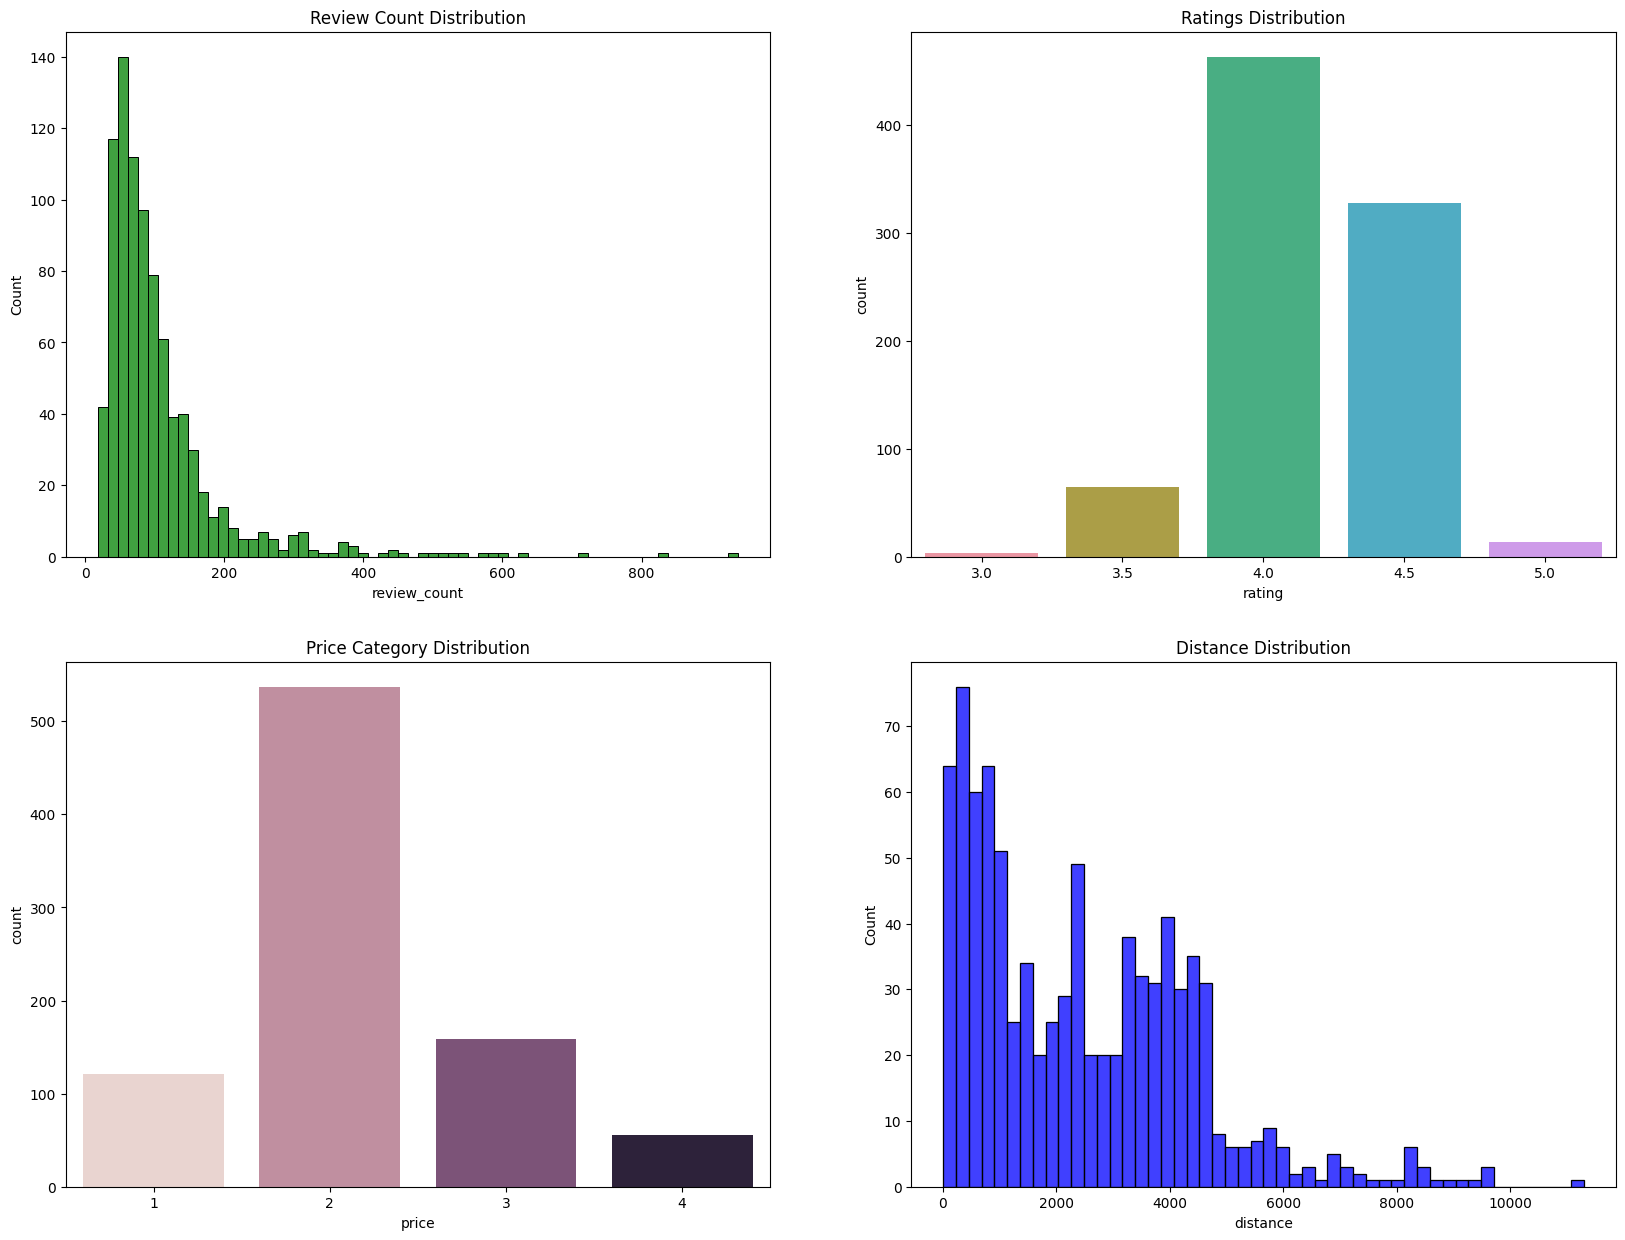

In [122]:
fig, axes = plt.subplots(2,2,figsize=(20,15))
sb.set_palette(sb.cubehelix_palette(4))
sb.histplot(clean_df['review_count'], color='g', ax=axes[0,0]).set_title('Review Count Distribution')
sb.countplot(x=clean_df['rating'], ax=axes[0,1]).set_title('Ratings Distribution')
sb.countplot(x=clean_df['price'], ax=axes[1,0]).set_title('Price Category Distribution')
sb.histplot(clean_df['distance'], color='b', ax=axes[1,1], bins=50).set_title('Distance Distribution')
plt.show()

As expected, we see that the ratings and price level for businesses follows roughly a normal distribution with the means of each roughly being $4.2$ and $2.2$ respectively. We can see this easily in the above plots which correspond to the relevant graph. Furthermore, we see that the distance distribution follows a power law. However, we see an unusual behaviour between $1000 - 3000$ meters where a gap has appeared. But we could also interprete this as naturaly behaviour and the anomaly belongs to the *spike* which occurs roughly from $3000 - 4000$ meters. We can hopefully attempt to explain either of these observations later.

### Category Analysis

#### Category Distribution

Not all the businesses listed by Yelp are of the same type. These businesses range from museums to restuarants. So to understand the data as a whole, we must first understand how the categories are distributed and their properties.

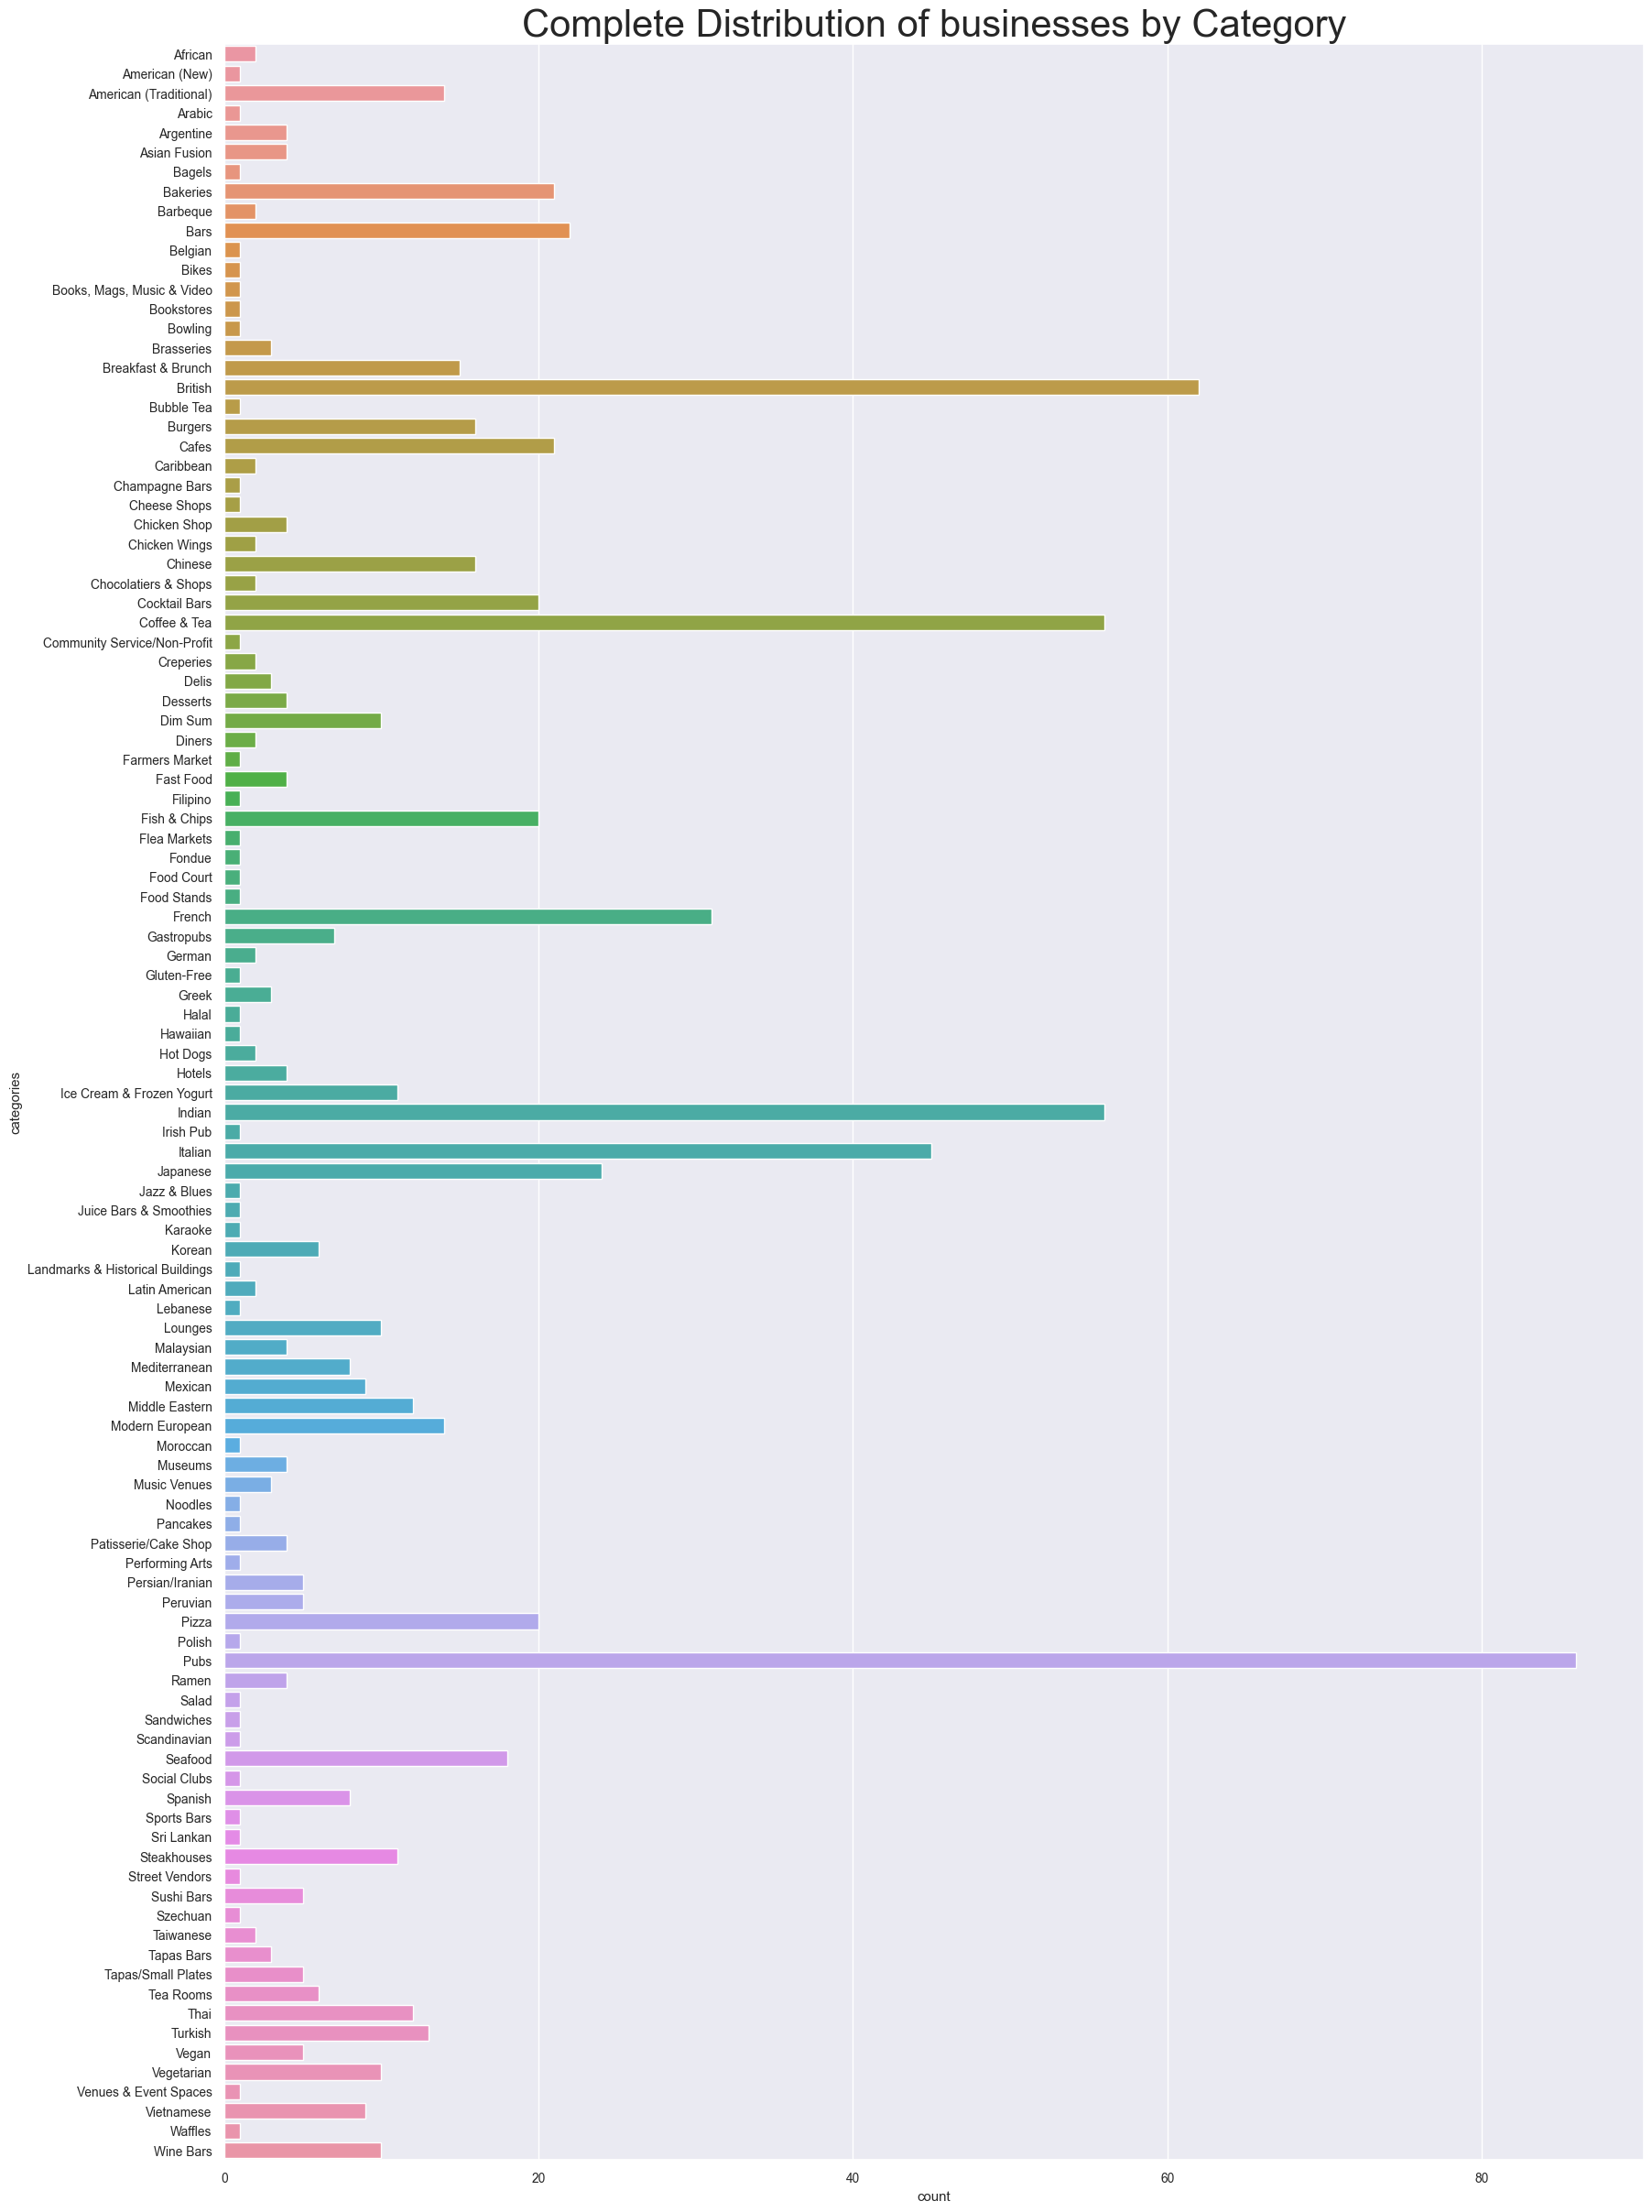

In [79]:
fig = plt.subplots(figsize = (20,30))
sb.set(font_scale=1)
sb.set_palette(sb.cubehelix_palette(1))
sb.countplot(y=clean_df['categories'].sort_values(ascending = True))
plt.title('Complete Distribution of businesses by Category',fontdict={'fontsize': 30})
plt.show()

Pubs                      86
British                   62
Indian                    56
Coffee & Tea              56
Italian                   45
French                    31
Japanese                  24
Bars                      22
Cafes                     21
Bakeries                  21
Pizza                     20
Cocktail Bars             20
Fish & Chips              20
Seafood                   18
Burgers                   16
Chinese                   16
Breakfast & Brunch        15
American (Traditional)    14
Modern European           14
Turkish                   13
Name: categories, dtype: int64


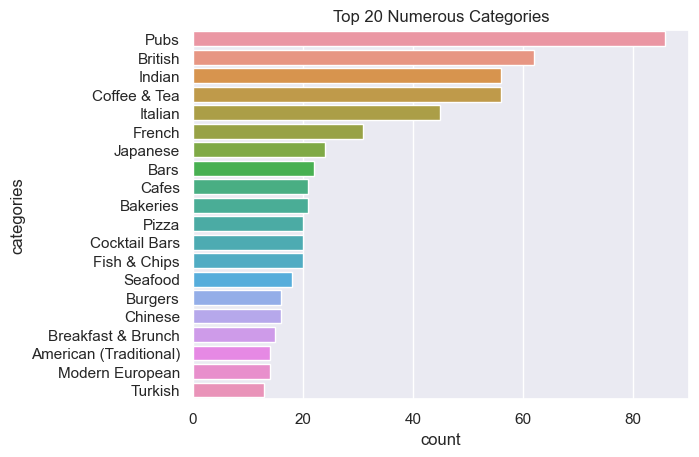

In [29]:
num = 20
fig = plt.subplots()
sb.set_palette(sb.cubehelix_palette(1))
top_cats =clean_df['categories'].value_counts()[0:num].index.tolist()
values = clean_df[clean_df['categories'].isin(top_cats)]['categories']
print(clean_df['categories'].value_counts()[0:num])
sb.countplot(y=values, order=clean_df['categories'].value_counts()[0:num].index)
plt.title(f'Top {num} Numerous Categories')
plt.show()

The above charts illustrate the total frequency of categories across London, along with the top 20 business categories. As expected we see *Pubs* and *British* businesses top this chart, with well-known favourites of the British public joining them with *Indian*, *Coffee & Tea* and *Italian* ranking $3^{\text{rd}}$, $4^{\text{th}}$ and $5^{\text{th}}$ respectively. However, we must address the potential conlfict with the category system applied by Yelp. For instance, we see that *Coffee & Tea* is a category, but there also exists a category named *Cafes*. What distinguished a business which sells coffee and tea to a cafe? Is this difference arbitrarily decided by the businesses owner or is determined by an algorithm developed by Yelp?

Another example is the category of *Fish & Chips*. An argument can be made for this category to be combined with the *British*, *Seafood* or even *Portuguese*. Why is this category not joined with the others? Furthermore, it is commonplace across England for *Fish & Chip* shops to be combines with *Chinese*. If listed on Yelp, what category is assigned to the business? How would our distribution be impacted if multiple category labels were listed by Yelp's API service? And even if data cleaning incorporate this problem, many choices made regarding this would be subjective and will most likely  be different dependent upon who conducts this analysis. For fairness,and without the opinion or a team to corroborate any decisions made, these categories will remain unchanged and will be treated as normal.

**MAIN TAKEAWAY**: Categories are distributed via a power law with the most frequent business types consisting of the expected type (*Pubs*, *British* and *Indian*). However ambiguity exists with the definition of categories and must be treated carefully.

#### Total Review Counts by Category

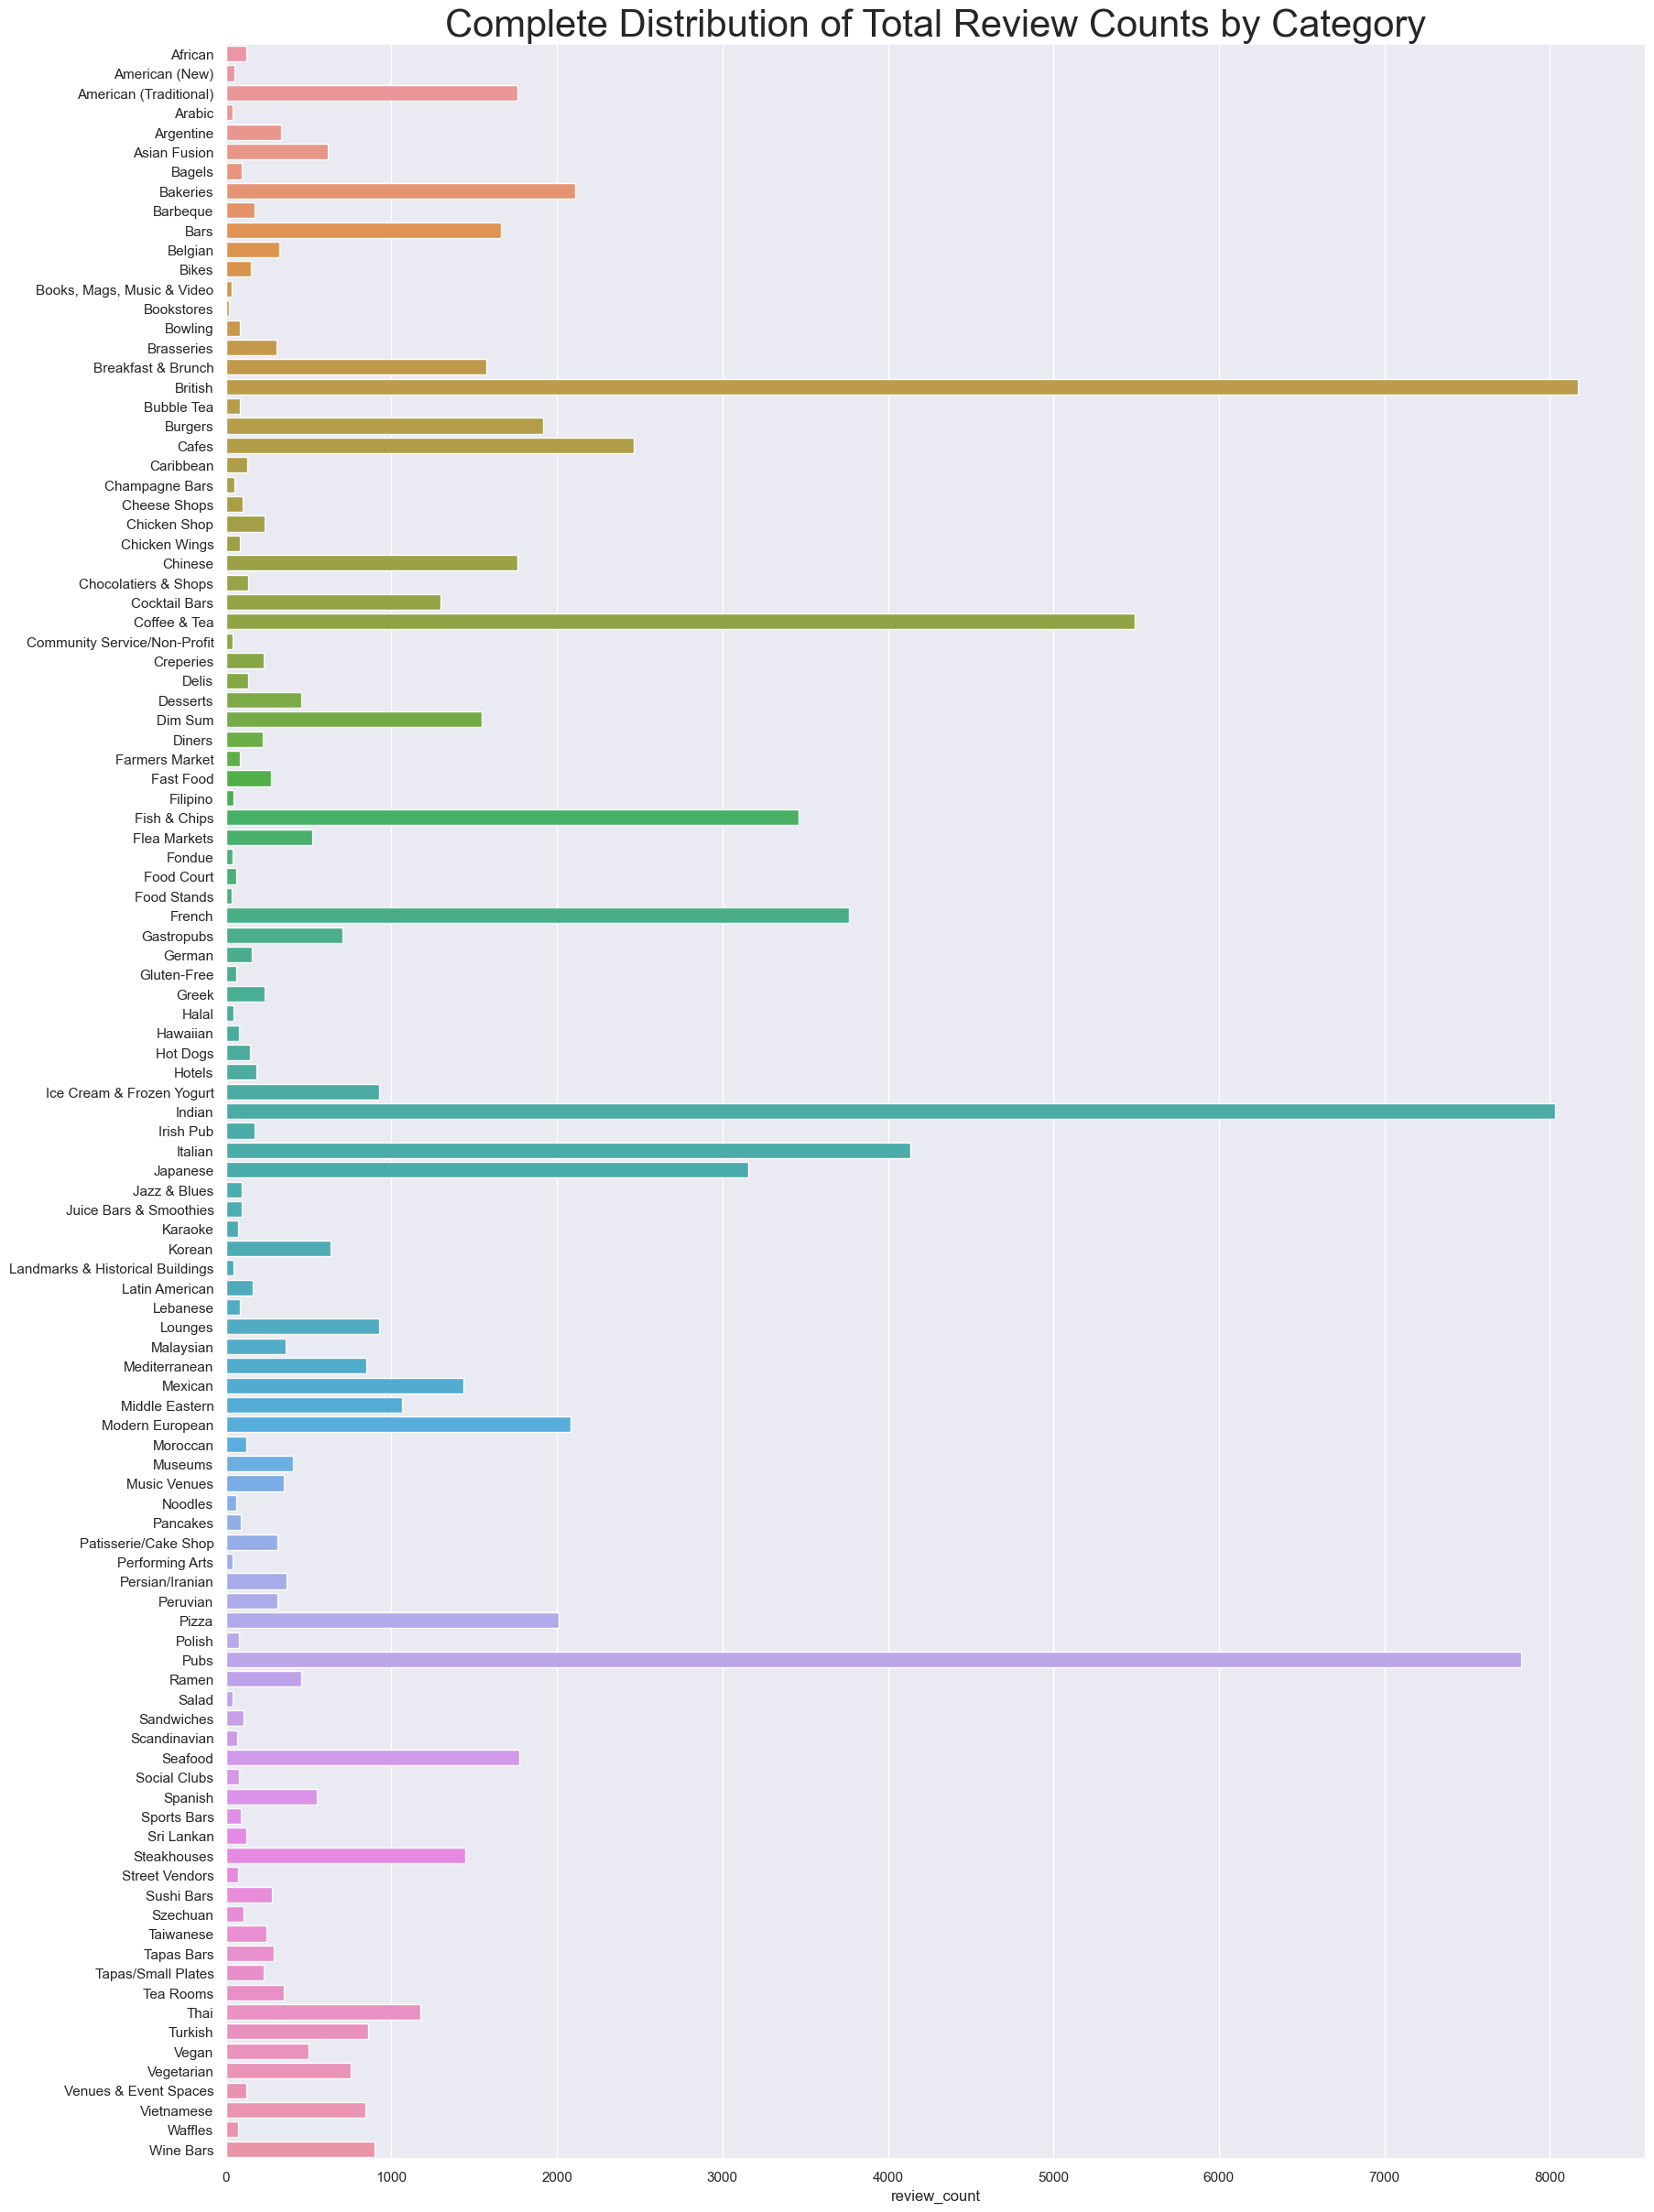

In [18]:
fig = plt.subplots(figsize = (20,30))
sb.set(font_scale=1)
sb.set_palette(sb.cubehelix_palette(1))
cat_review_counts = clean_df.groupby('categories')['review_count'].sum()
sb.barplot(x=cat_review_counts,y=cat_review_counts.index.tolist())
plt.title('Complete Distribution of Total Review Counts by Category',fontdict={'fontsize': 30})
plt.show()

categories
British                   8169
Indian                    8029
Pubs                      7824
Coffee & Tea              5492
Italian                   4138
French                    3766
Fish & Chips              3462
Japanese                  3158
Cafes                     2467
Bakeries                  2108
Modern European           2082
Pizza                     2012
Burgers                   1917
Seafood                   1772
Chinese                   1764
American (Traditional)    1759
Bars                      1664
Breakfast & Brunch        1571
Dim Sum                   1544
Steakhouses               1447
Name: review_count, dtype: int64


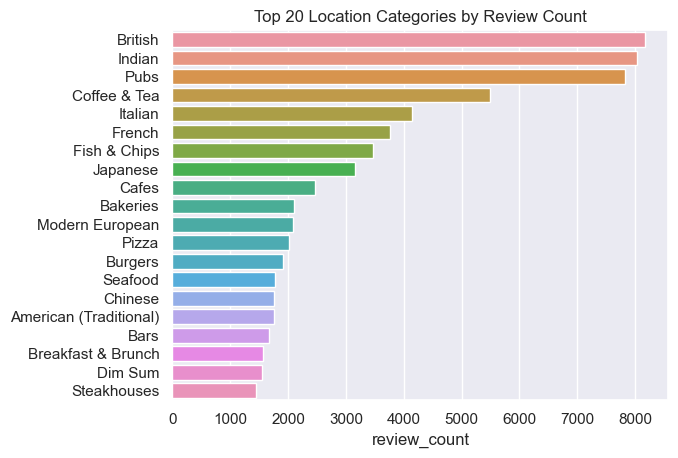

In [26]:
num = 20
fig = plt.subplots()
sb.set_palette(sb.cubehelix_palette(1))
top_cats = clean_df.groupby('categories')['review_count'].sum().sort_values(ascending = False)[0:num]
print(top_cats)
sb.barplot(x=top_cats,y=top_cats.index.tolist(), order=top_cats.index)
plt.title(f'Top {num} Location Categories by Review Count')
plt.show()

The above graphics illustrate the categories with the most amount of reviews, along with the top 20 of this distribution. As we'd expect in general, the categories that have the most businesses associated with this category have the most review counts. This can be explained intuitively as the more locations there are of this category, the more opportunities someone will have to leave a review. We can evaluate this be caluclating the correlation-coefficient for this relationship. Indeed;

In [160]:
cat_count = clean_df['categories'].value_counts().sort_index(ascending=True)
cat_review_count = clean_df.groupby('categories')['review_count'].sum().sort_index(ascending = True)

correlation_value = np.corrcoef([cat_count,cat_review_count])
print(f'The correlation coefficient between the category frequency and the category review count is:\n\n{correlation_value[0,1]}.')

The correlation coefficient between the category frequency and the category review count is:

0.9700928974051238.


A very strong correlation exists bewteen these two variables which reinforces our intuition regarding this. This behaviour can also be seen when comparing the top 20s for both of this plots. The top 5 of these charts share the same categories, although not in the exact same order. There distribution are also mirrored with both expressing a power law distribution. Due to the expremely high correlation between these two vairbale, we can create a relatively good modle which tried to predict one of the variables using the other as a linear proportion. Suppose $N_{reviews}$ and $f$ denotes the number of reviews a category will get in total and the number of businesses that are of teh given category respectively. Then the following can be proposed as the model for prediction;

$$
N_{reviews} \approx \alpha \cdot f,
$$

where $\alpha$ is an engagement constant which measures how often the general public will leave a review about a business. We can evaluated this constant by making $\alpha$ the subject of the expression and take the average of the values produced using the data we already have on London. We will do this in due course.

**MAIN TAKEAWAY**: The number of categories and the number of reviews given for each category have a very strong linear relation with each other. This relationship can be modeled by assuming they are directly proportional to eachother by an engagement constant, $\alpha$.

#### Review Count per Category

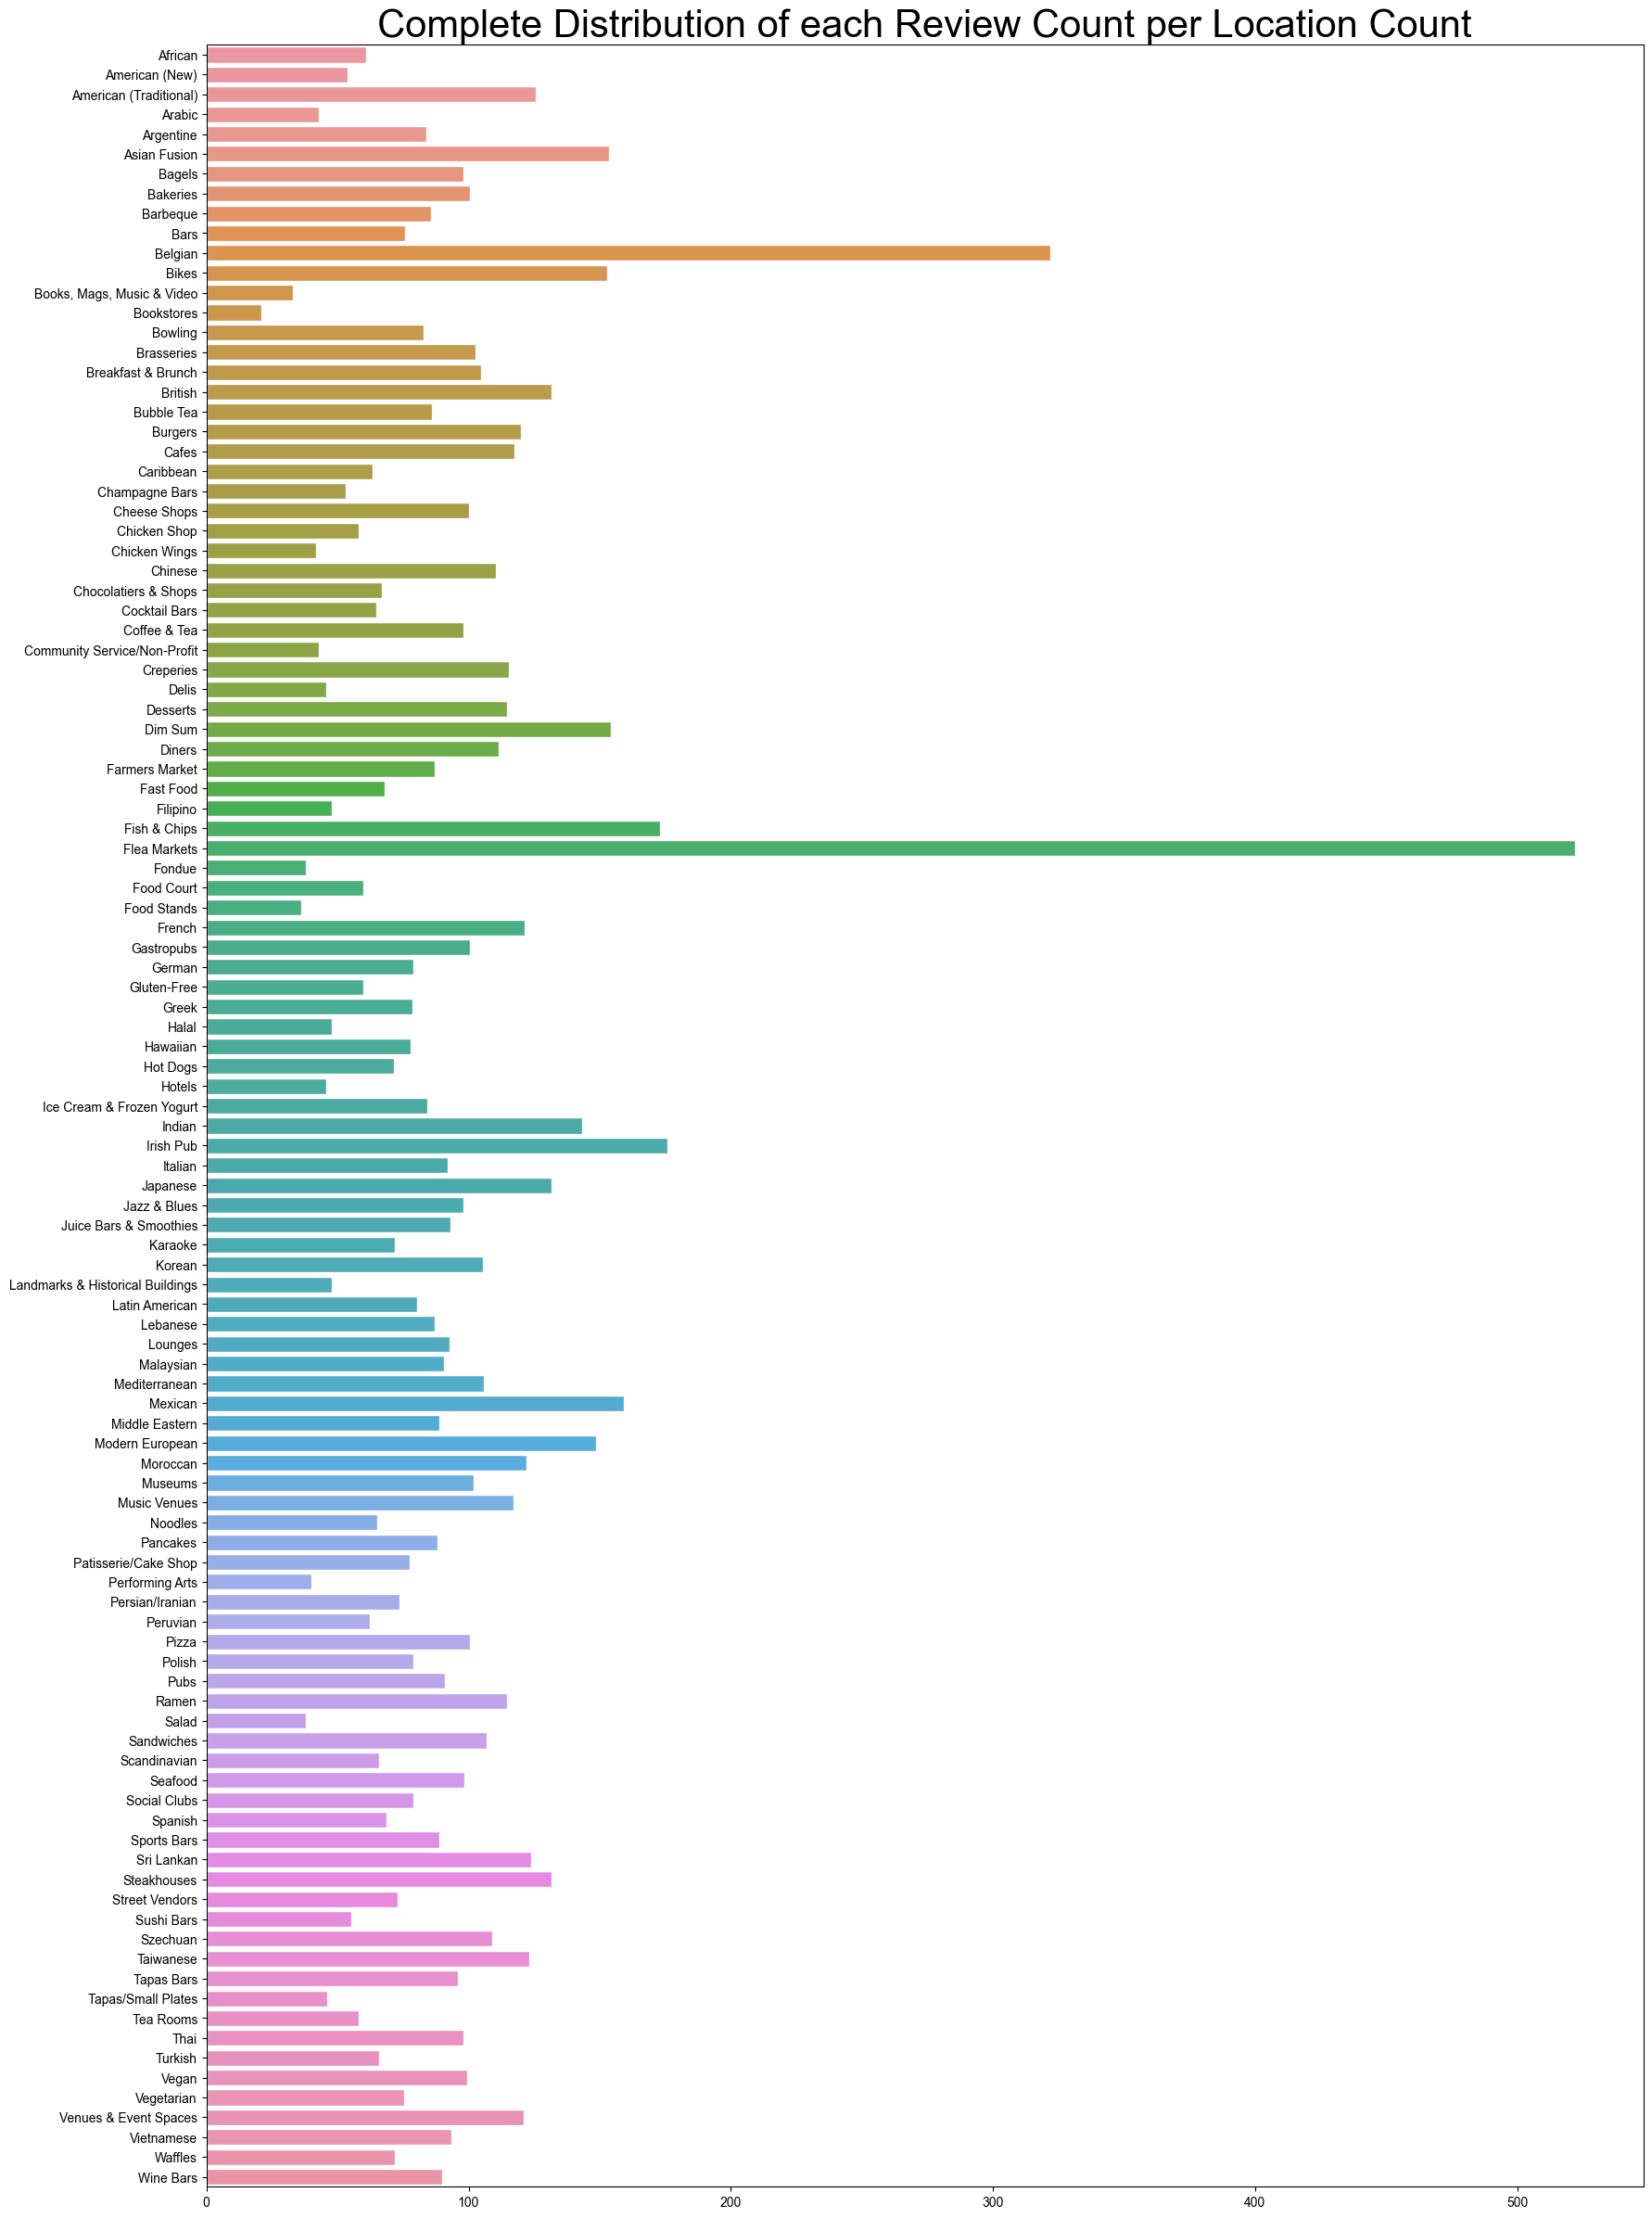

In [130]:
cats = clean_df['categories'].value_counts().index.sort_values(ascending=True).tolist()
total_num_cats = clean_df[clean_df['categories'].isin(cats)]['categories'].value_counts()
total_num_reviews = clean_df.groupby('categories')['review_count'].sum()

reviews_over_num = []
for cat in cats:
    frac = total_num_reviews[cat]/total_num_cats[cat]
    reviews_over_num.append(frac)

fig = plt.subplots(figsize = (20,30))
sb.set(font_scale=1)
sb.set_palette(sb.cubehelix_palette(1))
sb.barplot(x=reviews_over_num,y=cats)
plt.title('Complete Distribution of each Review Count per Location Count',fontdict={'fontsize': 30})
plt.show()

categories  reviews_per_location
40             Flea Markets            522.000000
10                  Belgian            322.000000
55                Irish Pub            176.000000
39             Fish & Chips            173.100000
68                  Mexican            159.333333
34                  Dim Sum            154.400000
5              Asian Fusion            153.500000
11                    Bikes            153.000000
70          Modern European            148.714286
54                   Indian            143.375000
17                  British            131.758065
57                 Japanese            131.583333
92              Steakhouses            131.545455
2    American (Traditional)            125.642857
91               Sri Lankan            124.000000
96                Taiwanese            123.000000
71                 Moroccan            122.000000
44                   French            121.483871
104   Venues & Event Spaces            121.000000
19                  Burgers            119.812500

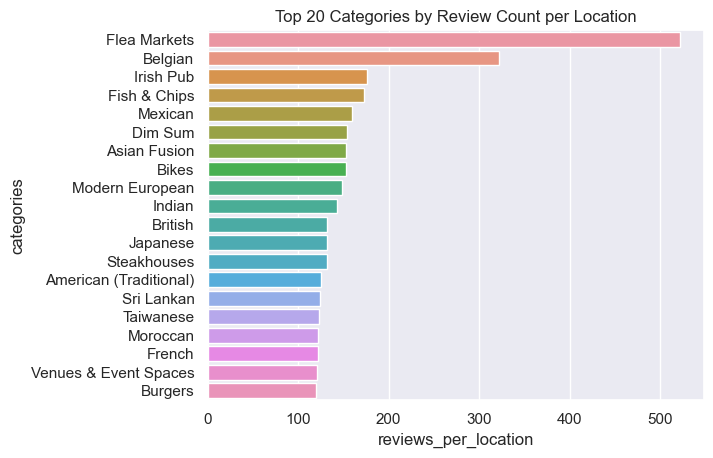

In [134]:
num = 20
fig = plt.subplots()
sb.set_palette(sb.cubehelix_palette(1))
df2 = pd.DataFrame({'categories':cats,'reviews_per_location':reviews_over_num})
df2 = df2.sort_values(by='reviews_per_location',ascending=False)
sb.barplot(x=df2['reviews_per_location'].iloc[0:num],y=df2['categories'].iloc[0:num])
plt.title(f'Top {num} Categories by Review Count per Location')
display(df2.iloc[0:num])
plt.show()

Now we have plotted the frequency of the average number of review left at each location for every category. These values can be interpreted as the engagement measure for each category of business. So for a business that is classified as a *Venues & Event Spaces* businesses can expect that they would have roughly 121 reviews. This approach does not consider the length of time that the business has been open for, however we have not been given this infomation from the Yelp API requests so we must assume that all these businesses have been open for roughly the same amount of time.

As for evalueting the engagement constant for our simple model, we can take the average of these values above to get a generale value for the London.

In [168]:
engagement_const = np.mean(df2['reviews_per_location'])
print(f'The engagement constant for London: {engagement_const}.')

The engagement constant for London: 94.60459231883989.


We see however an unexpected leading in the engagement level for a business category. We see that *Flea Markets* tops to chart with 522 reviews per location. We also seeTo explain this, we can have a look at the businesses classed as *Flea Markets*.

In [169]:
display(clean_df[(clean_df['categories'] == "Flea Markets") | (clean_df['categories'] == "Belgian")])

id            name  \
22   IYSKMlGpn--rfzyg9MpEyQ   Camden Market   
116  H-l4CDhIZ0uTfyv_lR1p7Q  Belgo Centraal   

                                             image_url  \
22   https://s3-media1.fl.yelpcdn.com/bphoto/-pxYKN...   
116  https://s3-media3.fl.yelpcdn.com/bphoto/KpgxHY...   

                                                   url  review_count  \
22   https://www.yelp.com/biz/camden-market-london-...           522   
116  https://www.yelp.com/biz/belgo-centraal-london...           322   

       categories  rating                                           location  \
22   Flea Markets     4.5  Camden Lock Place, Camden Town, London NW1 8AF...   
116       Belgian     4.0  50 Earlham Street, London WC2H 9LJ, United Kin...   

            phone     distance  price   latitude  longitude  
22   4.420376e+11  3258.491443      2  51.541502   -0.14573  
116  4.420781e+11   720.911888      2  51.513783   -0.12565

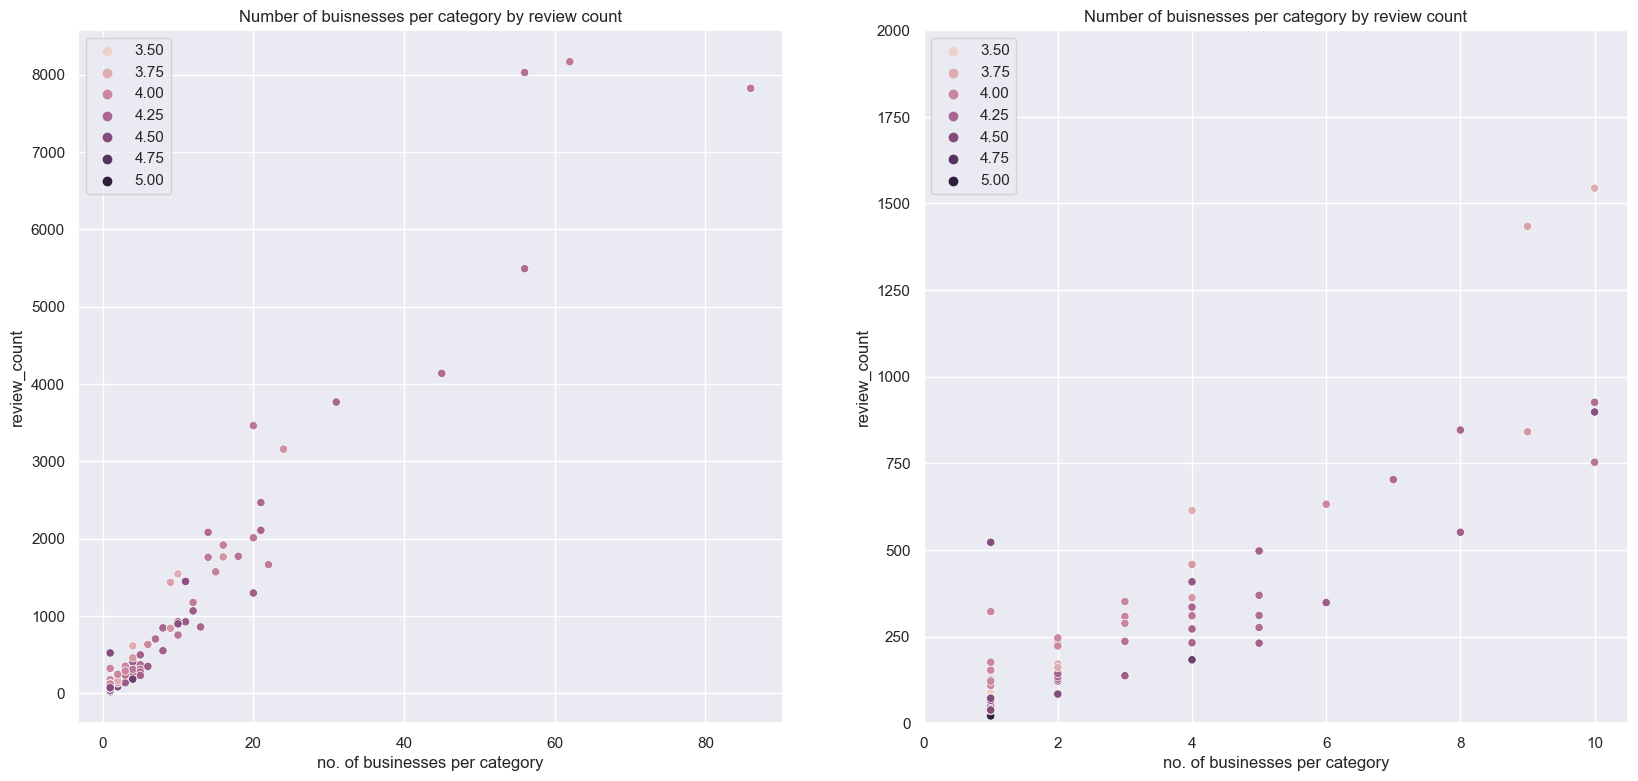

In [148]:
fig, axes = plt.subplots(1,2,figsize=(20,9))
average_rating_per_location = clean_df.groupby('categories')['rating'].sum()/(total_num_cats.sort_index(ascending=True))
plot1 = sb.scatterplot(
    x=total_num_cats.sort_index(ascending=True),
    y=total_num_reviews,
    hue = average_rating_per_location,
    ax = axes[0]
)
plot2 = sb.scatterplot(
    x=total_num_cats.sort_index(ascending=True),
    y=total_num_reviews,
    hue = average_rating_per_location,
    ax = axes[1]
)
plot2.set_xlim([0,10.5])
plot2.set_ylim([0,2000])
#plt.ylim([0,1000])
#plt.xlim([0,10])
plot1.set_xlabel('no. of businesses per category')
plot1.set_title('Number of buisnesses per category by review count')
plot2.set_xlabel('no. of businesses per category')
plot2.set_title('Number of buisnesses per category by review count')
plt.show()

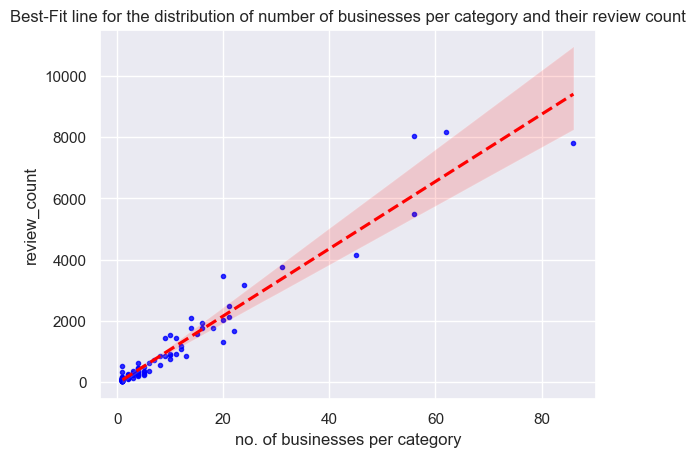

In [113]:
fig = plt.subplots()
sb.regplot(
    x=total_num_cats.sort_index(ascending=True),
    y=total_num_reviews,
    color='blue',
    marker='.',
    line_kws={'color':'red','linestyle':'--'},
    label=total_num_cats.sort_index(ascending=True).index
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('no. of businesses per category')
plt.title('Best-Fit line for the distribution of number of businesses per category and their review count')
plt.show()

### Mapping our data

In [73]:
london_map = folium.Map(
    location = [51.51283552118349, -0.135955810546875], 
    title='London',
    zoom_start=11.5
)

five_rating = folium.FeatureGroup(name = "Rating Level: 5")
four_point_five_rating = folium.FeatureGroup(name = "Rating Level: 4.5")
four_rating = folium.FeatureGroup(name = "Rating Level: 4")
three_point_five_rating = folium.FeatureGroup(name = "Rating Level: 3.5")
three_rating = folium.FeatureGroup(name = "Rating Level: 3")

for row in clean_df.index:
    rating = clean_df['rating'][row]
    if rating == 5:
        color = 'blue'
    elif rating == 4.5:
        color = 'lightblue'
    elif rating == 4:
        color = 'green'
    elif rating == 3.5:
        color = 'lightgreen'
    else:
        color = 'orange'

    marker = folium.Marker(
        [clean_df['latitude'][row], clean_df['longitude'][row]],
        popup = f"NAME: {clean_df['name'][row]},\nPRICING LEVEL: {clean_df['price'][row]},\nREVIEW COUNT: {clean_df['review_count'][row]}.",
        icon = folium.Icon(color=color)
    )

    if rating == 5:
        five_rating.add_child(marker)
    elif rating == 4.5:
        four_point_five_rating.add_child(marker)
    elif rating == 4:
        four_rating.add_child(marker)
    elif rating == 3.5:
        three_point_five_rating.add_child(marker)
    else:
        three_rating.add_child(marker)
    
london_map.add_child(five_rating)
london_map.add_child(four_point_five_rating)
london_map.add_child(four_rating)
london_map.add_child(three_point_five_rating)
london_map.add_child(three_rating)

london_map.add_child(folium.LayerControl())

london_map

In [71]:
london_map = folium.Map(
    location = [51.51283552118349, -0.135955810546875], #initial center of map
    title='London', #title of map
    zoom_start=11.5 #initial zoom strength of the map
)

one_price_group = folium.FeatureGroup(name = "Price Level: 1") #grouping for price group 1
two_price_group = folium.FeatureGroup(name = "Price Level: 2") #grouping for price group 2
three_price_group = folium.FeatureGroup(name = "Price Level: 3") #grouping for price group 3
four_price_group = folium.FeatureGroup(name = "Price Level: 4") #grouping for price group 4

for row in clean_df.index: #for each row index of the clean_Df index column
    price = clean_df['price'][row] #gather price level for that row 
    if price == 4: #determine the colour of the marker
        colour = 'red'
    elif price == 3:
        colour = 'orange'
    elif price == 2:
        colour = 'green'
    else:
        colour = 'blue'

    marker = folium.Marker(
        [clean_df['latitude'][row], clean_df['longitude'][row]], #latitude and longitude from the clean_df columns
        popup = f"NAME: {clean_df['name'][row]},\nRATING LEVEL: {clean_df['rating'][row]},\nREVIEW COUNT: {clean_df['review_count'][row]}.", #what infomation pops up when marker is selected
        icon = folium.Icon(color=colour) #set the colour of the marker for each price group
    )

    if price == 4: #determine which grouping to put the marker in by the price level
        four_price_group.add_child(marker)
    elif price == 3:
        three_price_group.add_child(marker)
    elif price == 2:
        two_price_group.add_child(marker)
    else:
        one_price_group.add_child(marker)

london_map.add_child(four_price_group) #add each grouping to the map
london_map.add_child(three_price_group)
london_map.add_child(two_price_group)
london_map.add_child(one_price_group)

london_map.add_child(folium.LayerControl()) #add the group control to the map

london_map #present map

In [86]:
london_map = folium.Map(
    location = [51.51283552118349, -0.135955810546875], #initial center of map
    title='London', #title of map
    zoom_start=11.5 #initial zoom strength of the map
)

v_low_group = folium.FeatureGroup(name = "Review Count: 1 - 50")
low_group = folium.FeatureGroup(name = "Review Count: 51 - 100") #grouping for price group 1
mid_group = folium.FeatureGroup(name = "Review Count: 101 - 150") #grouping for price group 2
high_group = folium.FeatureGroup(name = "Review Count: 151 - 250") #grouping for price group 3
v_high_group = folium.FeatureGroup(name = "Review Count: 251 - 1000") #grouping for price group 3

for row in clean_df.index: #for each row index of the clean_Df index column
    reviews = clean_df['review_count'][row] #gather price level for that row 
    if reviews <= 50: #determine the colour of the marker
        colour = 'red'
    elif reviews <= 100:
        colour = 'orange'
    elif reviews <= 150:
        colour = 'green'
    elif reviews <= 250:
        colour = 'blue'
    else:
        colour = 'purple'

    marker = folium.Marker(
        [clean_df['latitude'][row], clean_df['longitude'][row]], #latitude and longitude from the clean_df columns
        popup = f"NAME: {clean_df['name'][row]},\nRATING LEVEL: {clean_df['rating'][row]},\nPRICE LEVEL: {clean_df['price'][row]}.", #what infomation pops up when marker is selected
        icon = folium.Icon(color=colour) #set the colour of the marker for each price group
    )

    if reviews <= 50: #determine which grouping to put the marker in by the price level
        v_low_group.add_child(marker)
    elif reviews <= 100:
        low_group.add_child(marker)
    elif reviews <= 150:
        mid_group.add_child(marker)
    elif reviews <= 250:
        high_group.add_child(marker)
    else:
        v_high_group.add_child(marker)

london_map.add_child(v_low_group) #add each grouping to the map
london_map.add_child(low_group)
london_map.add_child(mid_group)
london_map.add_child(high_group)
london_map.add_child(v_high_group)

london_map.add_child(folium.LayerControl()) #add the group control to the map

london_map #present map

In [19]:
list_coor = clean_df[['name','latitude','longitude']].values.tolist()

map_new = folium.Map()
for coor in list_coor:
    map_new.add_child(folium.Marker(location=[coor[1],coor[2]],popup=coor[0],icon=folium.Icon(color='green')))

map_new.save('yelp_location_london.html')

### Summary

#### Category

#### Geo-Location